In [1]:
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn import metrics
from keras import regularizers
from keras.layers import Dense, Activation, Input, Dropout, BatchNormalization
from keras.models import Sequential
from keras_tqdm import TQDMNotebookCallback as ktqdm
from tqdm import tqdm_notebook as tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from statsmodels.distributions.empirical_distribution import ECDF
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_curve, average_precision_score, confusion_matrix

Using TensorFlow backend.


## Reproducibility

In [2]:
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(42)
random.seed(42)
tf.set_random_seed(42)

## Creation of uniform distribution of predecessors

In [3]:
step = 500
size = 500000
n = step * size
width = np.ceil(np.log2(n)).astype(int)
predecessors = np.arange(0, n, step)
predecessors = np.array([
    (predecessors[i]) for i in range(size)
]).astype(int)
predecessors, predecessors.shape

(array([        0,       500,      1000, ..., 249998500, 249999000,
        249999500]), (500000,))

In [4]:
cumulative_predecessors = np.array([i / size for i in range(size)])
cumulative_predecessors, cumulative_predecessors.size

(array([0.00000e+00, 2.00000e-06, 4.00000e-06, ..., 9.99994e-01,
        9.99996e-01, 9.99998e-01]), 500000)

## Bit conversion in digits of predecessors

In [5]:
predecessors = np.array([
    list(np.binary_repr(i, width)) for i in np.arange(0, n, step)
]).astype(int)
np.set_printoptions(threshold=100)
predecessors, predecessors.shape

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 1, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 1, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 1, 0, 0]]), (500000, 28))

## Create training + testing set

In [6]:
x_train, x_test, y_train, y_test = train_test_split(
    predecessors, 
    cumulative_predecessors, 
    test_size=0.25, 
    random_state=42)

In [7]:
x_train.shape, y_train.shape

((375000, 28), (375000,))

In [8]:
x_test.shape, y_test.shape

((125000, 28), (125000,))

## Network Metrics

In [9]:
def plot_history_graph(history, index, label):
    """Plot the graph for the given history metrics."""
    plt.plot(history.history[index], label='Training %s = %0.6f' % (label, history.history[index][-1]))
    plt.plot(history.history['val_%s'%index] , label='Testing %s = %0.6f' % (label, history.history['val_%s'%index][-1]))
    plt.title('Model %s'%label, fontsize=15)
    plt.ylabel(label)
    plt.xlabel('epoch')
    plt.legend(loc='lower right')
    plt.figure(figsize=(40,20))

## Define function to build the model

In [14]:
from keras import metrics

def build_model(neurons):
    """ Return keras network model """
    model = Sequential()
    model.add(Dense(neurons * 2, input_dim=neurons, name="Input_dense_layer"))
    model.add(Activation("sigmoid", name="Input_Sigmoid"))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(Dense(1, name="Output_dense_layer"))
    model.add(Activation("sigmoid", name="Output_Sigmoid"))
    model.add(BatchNormalization())
    model.compile(
        loss='mean_squared_error', optimizer='sgd', metrics=['mean_absolute_error'])

    return model

## Construction of the model

In [15]:
model = build_model(width)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_dense_layer (Dense)    (None, 56)                1624      
_________________________________________________________________
Input_Sigmoid (Activation)   (None, 56)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 56)                0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 56)                224       
_________________________________________________________________
Output_dense_layer (Dense)   (None, 1)                 57        
_________________________________________________________________
Output_Sigmoid (Activation)  (None, 1)                 0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 1)                 4         
Total para

In [12]:
history = model.fit(
    x_train, 
    y_train,
    epochs=20,
    shuffle=True,
    batch_size=264,
    verbose=0,
    callbacks=[ktqdm(metric_format="{name}: {value:e}")],
    validation_data=(x_test, y_test)
)

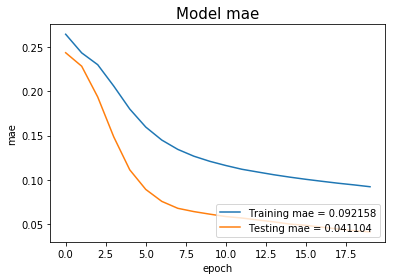

<Figure size 2880x1440 with 0 Axes>

In [16]:
plot_history_graph(history, 'mean_absolute_error', 'mae')

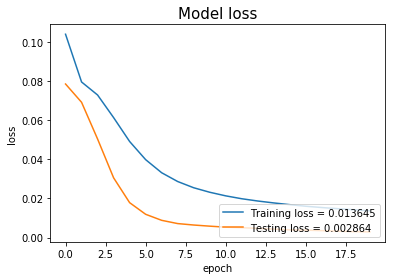

<Figure size 2880x1440 with 0 Axes>

In [17]:
plot_history_graph(history, 'loss', 'loss')